### 1. Build Hessian Matrix following the problem statement.

In [1]:
import numpy as np

hessian_h2o = np.array([[14.6,-0.199,0.884],
                        [-0.199,14.6,0.884],
                        [0.884,0.884,4.55]])
# Compute the eigenvalues and eigenvectors of the Hessian
eigenvalues, eigenvectors = np.linalg.eigh(hessian_h2o)

The eigenvectors of the Hessian matrix are directions in terms of  vibrational modes of the molecule. Each column of the eigenvector matrix represents a vibrational mode.

In [2]:
eigenvectors

array([[-8.76552261e-02, -7.01652736e-01,  7.07106781e-01],
       [-8.76552261e-02, -7.01652736e-01, -7.07106781e-01],
       [ 9.92286815e-01, -1.23963209e-01, -1.22124533e-15]])

### Simple Huckel Method Implemantation Problem 3 to 6 are solved using SHM

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import IPythonConsole
from rdkit.Chem import rdEHTTools
IPythonConsole.ipython_showProperties = True
from rdkit.Chem import rdDepictor,rdDetermineBonds
rdDepictor.SetPreferCoordGen(True)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
class Simple_Huckel:
    def __init__(self,smiles,chrg = 0):
        self.smiles = smiles
        self.mol = Chem.MolFromSmiles(smiles)
        self.chrg = chrg
        self.n_atoms = self.mol.GetNumAtoms()
        self.n_bonds = self.mol.GetNumBonds()
        self.n_pi = self.n_atoms // 2
        self.chrg_occ = self.chrg // 2 if self.chrg > 0 else -((-self.chrg) // 2)
        self.occupied_mos = [2] * (self.n_pi - self.chrg_occ)
        if self.chrg < 0 and self.chrg % 2:
            self.occupied_mos += [1]
        elif self.chrg > 0 and self.chrg % 2:
            try:
                self.occupied_mos[-1] = 1
            except:
                raise ValueError('SHM cannot be applied because charges are higher than the number of pi electrons')
        if len(self.occupied_mos) > self.n_atoms:
            raise ValueError('SHM cannot be applied because the molecule has more occupied orbitals than the number of pi orbitals')
        
        self.adjacency_matrix = np.zeros((self.n_atoms, self.n_atoms))
        if self.check_conjugation():
            self.build_adjacency_matrix()
            self.solve()
            self.get_energy()
            self.get_atomic_charges()
            self.get_bond_order()
    
    def check_conjugation(self):
        if self.smiles in {'C=C','C=CC'}:
            return True
        for bond in self.mol.GetBonds():
            if not bond.GetIsConjugated():
                print('This molecule is not suitable for the Simple Hückel Method')
                return False
        return True

    def build_adjacency_matrix(self):
        for bond in self.mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            self.adjacency_matrix[i, j] = -1
            self.adjacency_matrix[j, i] = -1
            # get atom names of each bond
            atom_i = self.mol.GetAtomWithIdx(i).GetSymbol()
            atom_j = self.mol.GetAtomWithIdx(j).GetSymbol()
            # this is for problem 6(b)
            if atom_i in {'O'} or atom_j in {'O'}:
                if atom_i == 'O':
                    self.adjacency_matrix[i, i] = -2
                else:
                    self.adjacency_matrix[j, j] = -2

    def solve(self):
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.adjacency_matrix)
        for i in range(self.n_atoms):
            if self.eigenvalues[i] < 0.000000001 and self.eigenvalues[i] > -0.000000001:
                self.eigenvalues[i] = 0
    
    def get_energy(self):
        '''
        Compute the resonance energy of the molecule (beta)
        '''
        self.reson_energy = 0
        for i in range(len(self.occupied_mos)):
            self.reson_energy += self.occupied_mos[i] * self.eigenvalues[i]
    
    def get_atomic_charges(self):
        '''
        Compute the atomic charges of the molecule
        '''
        self.atomic_charges = np.zeros(self.n_atoms)
        for i in range(self.n_atoms):
            for j in range(len(self.occupied_mos)):
                self.atomic_charges[i] += self.occupied_mos[j] * self.eigenvectors[i,j] ** 2
            self.atomic_charges[i] = 1 - self.atomic_charges[i]
        self.atomic_charges = np.where(np.abs(self.atomic_charges) < 0.00000001, 0, self.atomic_charges)
        # SetProp self.mol with the atomic charges
        atomic_charges = [str(round(charge, 3)) for charge in self.atomic_charges]
        for i in range(self.n_atoms):
            self.mol.GetAtomWithIdx(i).SetProp('atomNote', f'{str(atomic_charges[i])}e')

    def get_bond_order(self):
        '''
        Compute the bond orders of the molecule
        '''
        self.bond_orders = np.zeros(self.n_bonds)
        # get the bond orders
        for bond in self.mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            for k in range(len(self.occupied_mos)):
                self.bond_orders[bond.GetIdx()] += self.occupied_mos[k] * self.eigenvectors[i,k] * self.eigenvectors[j,k]
            self.bond_orders[bond.GetIdx()] = 1 + self.bond_orders[bond.GetIdx()]
        
        # SetProp self.mol with the bond orders
        bond_orders = [str(round(order, 1)) for order in self.bond_orders]
        for i in range(self.n_bonds):
            self.mol.GetBondWithIdx(i).SetProp('bondNote', bond_orders[i])


### Problem 3

In [5]:
benzene = Simple_Huckel('c1ccccc1')
ethylene = Simple_Huckel('C=C')
stablization_energy = benzene.reson_energy - 3 * ethylene.reson_energy
print(f'The stabilization energy of benzene is {-stablization_energy}\u03B2')

The stabilization energy of benzene is 2.0β


In [6]:
hexatriene = Simple_Huckel('C=C/C=C/C=C')
stablization_energy = hexatriene.reson_energy - 3 * ethylene.reson_energy
# round to 2 decimal places
stablization_energy = round(stablization_energy, 2)
print(f'The stabilization energy of hexatriene is {-stablization_energy}\u03B2')


The stabilization energy of hexatriene is 0.99β


In [7]:
# cyclobutadiene and butadiene
cyclobutadiene = Simple_Huckel('C1=CC=C1')
butadiene = Simple_Huckel('C=CC=C')
stablization_energy = cyclobutadiene.reson_energy - 2 * ethylene.reson_energy
print(f'The stabilization energy of cyclobutadiene is {-stablization_energy}\u03B2')
stablization_energy = butadiene.reson_energy - 2 * ethylene.reson_energy
# round the result to 2 decimal places
stablization_energy = round(stablization_energy, 2)
print(f'The stabilization energy of butadiene is {-stablization_energy}\u03B2')


The stabilization energy of cyclobutadiene is -0.0β
The stabilization energy of butadiene is 0.47β


### Problem 5. Polarity of Azulene

In [10]:
# Azulene
azulene = Simple_Huckel('c1cccc2cccc2c1')
azulene.eigenvalues

array([-2.31027685, -1.65157231, -1.35567429, -0.88697524, -0.47726   ,
        0.40039232,  0.73764031,  1.5792181 ,  1.86921398,  2.09529399])

In [9]:
# this is SHM orbitals
pd.DataFrame(azulene.eigenvectors)

,0,1,2,3,4,5,6,7,8,9
0,-0.199809,0.433267,3.570602e-01,0.159779,-3.354972e-01,-0.102278,-4.840573e-01,0.269711,0.404503,1.601194e-01
1,-0.172974,0.524672,-4.440892e-16,0.360277,3.747003e-16,0.510887,-5.551115e-16,-0.341575,-0.432805,-7.216450e-16
2,-0.199809,0.433267,-3.570602e-01,0.159779,3.354972e-01,-0.102278,4.840573e-01,0.269711,0.404503,-1.601194e-01
3,-0.288640,0.190900,-4.840573e-01,-0.218558,1.601194e-01,-0.469936,-3.570602e-01,-0.084357,-0.323297,3.354972e-01
4,-0.467029,-0.117982,-2.991638e-01,-0.353634,-2.590786e-01,0.290436,-2.206753e-01,-0.136492,0.199808,-5.428459e-01
5,-0.323298,-0.267774,-2.206753e-01,0.258527,-5.428459e-01,0.063211,2.991638e-01,0.436401,-0.249996,2.590786e-01
6,-0.279878,-0.324265,7.355228e-16,0.582941,7.216450e-16,-0.315746,-1.526557e-16,-0.552680,0.267488,-2.081668e-16
7,-0.323298,-0.267774,2.206753e-01,0.258527,5.428459e-01,0.063211,-2.991638e-01,0.436401,-0.249996,-2.590786e-01
8,-0.467029,-0.117982,2.991638e-01,-0.353634,2.590786e-01,0.290436,2.206753e-01,-0.136492,0.199808,5.428459e-01
9,-0.288640,0.190900,4.840573e-01,-0.218558,-1.601194e-01,-0.469936,3.570602e-01,-0.084357,-0.323297,-3.354972e-01


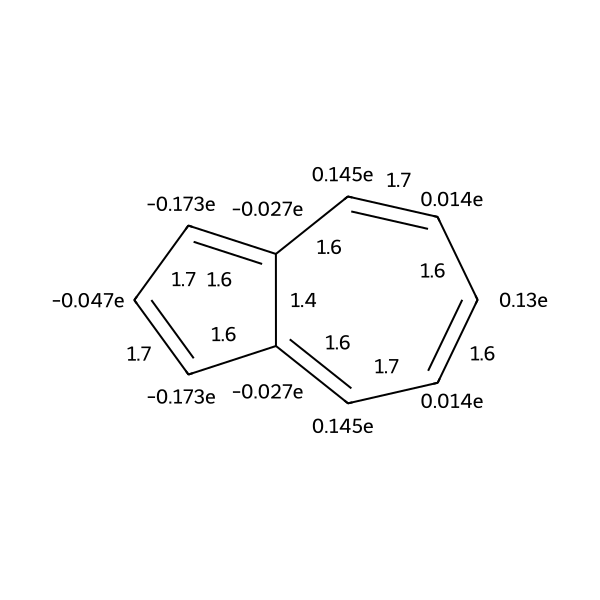

In [11]:
# draw azulene.mol with bigger size
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
img = Draw.MolToImage(azulene.mol, size=(600,600))
img

### Problem 6 SHM of three molecules with exocyclic carbon atoms

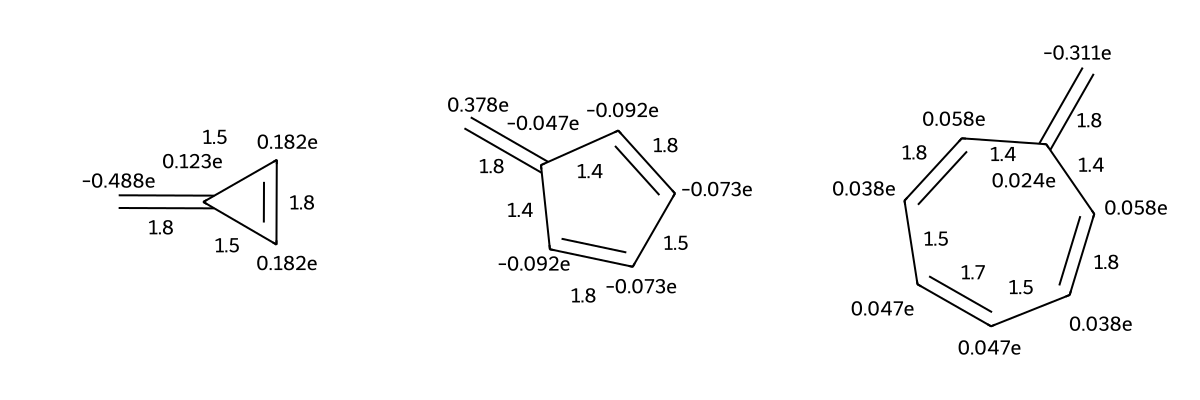

In [12]:
smiles = ['C=C1C=C1','C=C1C=CC=C1','C=C1C=CC=CC=C1']
mols = []
for smile in smiles:
    molecule = Simple_Huckel(smile)
    mols.append(molecule.mol)

# Draw the molecules in grid
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400, 400))
img

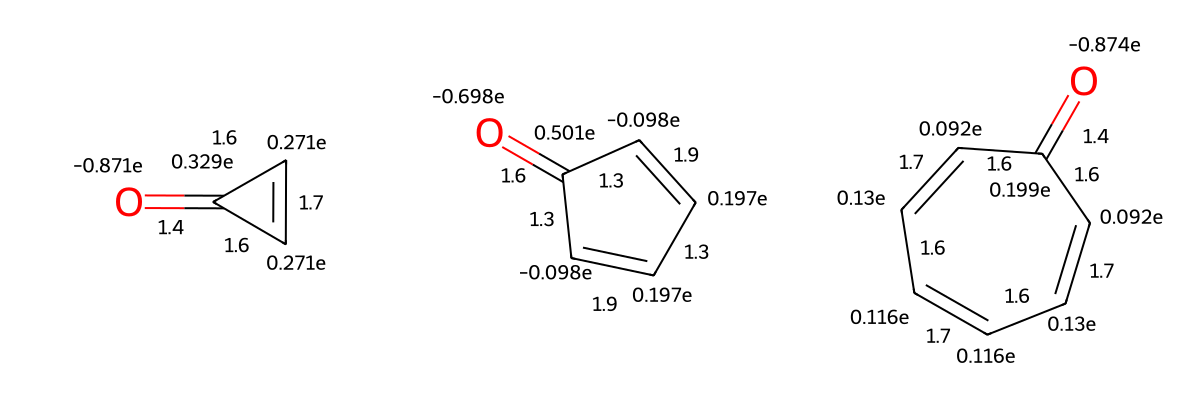

In [14]:
smiles = ['O=C1C=C1','O=C1C=CC=C1','O=C1C=CC=CC=C1']
mols = []
for smile in smiles:
    molecule = Simple_Huckel(smile)
    mols.append(molecule.mol)

img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400, 400))
img

### Implementation of extended Huckel method using Slater-type minimal basis sets
$$
1s = \sqrt{\frac{\zeta^3}{\pi}}e^{-\zeta r}              
$$
$$
2s = \sqrt{\frac{\zeta^5}{3\pi}}re^{-\zeta r}
$$
$$
2p_{{x,y,z}} = \sqrt{\frac{\zeta^5}{\pi}}e^{-\zeta r}{x,y,z}
$$

- $\zeta$ is a constant related to the effective nuclear charge


In [15]:
from dataclasses import dataclass, field
import math
from math import inf
from scipy import integrate

@dataclass
class Slater:
    coord: list
    atom: str
    zeta: float = field(init=False)
    zeta_dict = {'H': 1.3, 'He': 2.0925, 'Li': 0.65, 'C': 1.625, 'F': 2.425, 'O': 2.275}

    def __post_init__(self):
        self.zeta = self.zeta_dict[self.atom]
        self.coord = [coord / 0.529177 for coord in self.coord]  # Convert to Bohr upon initialization
        self.gen_orbs()

    def gen_orbs(self):
        self.orbs = []
        if self.atom in {'H', 'He'}:
            self.orbs.append(self.build_1s)
        elif self.atom in {'Li', 'C', 'F', 'O'}:
            self.orbs.append(self.build_2s)
            for p_orbital in ['px', 'py', 'pz']:
                self.orbs.append(lambda x, y, z, p=p_orbital: self.build_2p(x, y, z, p))

    def radial_distance(self, x, y, z):
        return math.sqrt((x - self.coord[0])**2 + (y - self.coord[1])**2 + (z - self.coord[2])**2)

    def exponential_decay(self, r):
        return math.exp(-self.zeta * r)

    def build_1s(self, x, y, z):
        r = self.radial_distance(x, y, z)
        return math.sqrt(self.zeta**3 / math.pi) * self.exponential_decay(r)

    def build_2s(self, x, y, z):
        r = self.radial_distance(x, y, z)
        return math.sqrt(self.zeta**5 / (3 * math.pi)) * r * self.exponential_decay(r)

    def build_2p(self, x, y, z, orbital_type):
        r = self.radial_distance(x, y, z)
        factor = math.sqrt(self.zeta**5 / math.pi) * self.exponential_decay(r)
        if orbital_type == 'px':
            return factor * (x - self.coord[0])
        elif orbital_type == 'py':
            return factor * (y - self.coord[1])
        elif orbital_type == 'pz':
            return factor * (z - self.coord[2])
        else:
            raise ValueError("Invalid orbital type specified")


## Extended Huckel Method
$\mathbf{HC} = \mathbf{SC}\epsilon$
- H is the Hamiltonian matrix
- c is the coefficient matrix
- S is the overlap matrix
- $\epsilon$ is the energy matrix
### Overlap Matrix
$S_{ij} = \int \phi_i' \phi_j' dv$
- $\phi_i'$ and $\phi_j'$ are the normalized atomic orbitals
### Hamiltonian Matrix
$H_{ii} = -I_{i}$ \
$H_{ij} = -\frac{1}{2}KS_{ij}(I_{i} + I_{j})$
- K is a Wolfsberg–Helmholz constant
- I is the ionization energies of each orbital
- S is the overlap matrix
### Orthogonalizing the matrix
$\mathbf{S} = \mathbf{P}\mathbf{\Omega} \mathbf{P}^{-1}$ \
$\mathbf{S}^{-\frac{1}{2}} = \mathbf{P}\mathbf{\Omega}^{-\frac{1}{2}}\mathbf{P}^{-1}$
### Transform $\mathbf{H}$ to $\mathbf{H}'$ and Diagonalize $\mathbf{H}'$
$\mathbf{H}'$ = $\mathbf{S}^{-\frac{1}{2}}\mathbf{H}\mathbf{S}^{-\frac{1}{2}}$\
$\mathbf{H}' = \mathbf{C}'\epsilon\mathbf{C}'^{-1}$
### Transform $\mathbf{C}'$ to $\mathbf{C}$
$\mathbf{C} = \mathbf{S}^{-\frac{1}{2}}\mathbf{C}'$


In [16]:


class extended_huckel:
    '''
    This is a class to run the extended Hückel method using the minimal slater-type orbital basis set.
    It only works for s and p orbitals as for now.
    '''
    def __init__(self,molfile,chrg = 0,ionization_energy = None,numerical = False):
        self.molfile = molfile
        self.mol = Chem.MolFromXYZFile(molfile)
        self.numerical = numerical
        try:
            rdDetermineBonds.DetermineBonds(self.mol,charge=chrg,useHueckel=True)
        except:
            pass
        self.n_atoms = self.mol.GetNumAtoms()
        self.n_bonds = self.mol.GetNumBonds()
        self.conf = self.mol.GetConformer()
        self.atomnames = [atom.GetSymbol() for atom in self.mol.GetAtoms()]
        self.ionization_energy = {'H':[13.6],
                                  'He':[24.6],
                                  'F':[40,18.1,18.1,18.1],
                                  'Li':[5.4,3.5,3.5,3.5],
                                  'C':[21.4,11.4,11.4,11.4],
                                  'O':[32.3,14.8,14.8,14.8]} \
                                if not ionization_energy else ionization_energy
        self.build_slater_orbs()
        self.calc()
    
    
    def calc(self):
        '''
        Run the extended Hückel method
        '''
        self.build_overlap_matrix()
        self.build_hamiltonian_matrix()
    
    def build_slater_orbs(self):
        '''
        Build the slater-type orbitals for each atom in the molecule
        '''
        self.atomcoords = self.conf.GetPositions()
        self.mol_orbs = []
        for i in range(self.n_atoms):
            atom = self.atomnames[i]
            coord = self.atomcoords[i]
            self.mol_orbs.extend(Slater(coord,atom).orbs)

    def build_overlap_matrix(self):
        '''
        Build the overlap matrix using Scipy numerical integration.
        Super slow, but it works.
        Better method should be from this paper: 10.1063/1.1747150.
        '''
        if self.numerical:
            self.ovlp = np.zeros((len(self.mol_orbs),len(self.mol_orbs)))
            for i, orb_a in enumerate(self.mol_orbs):
                self.ovlp[i][i] = 1
                for j,orb_b in tqdm(enumerate(self.mol_orbs[i+1:])):
                    x_limits = (-inf, inf)
                    y_limits = (-inf, inf)
                    z_limits = (-inf, inf)
                    def func(x,y,z):
                        return orb_a(x,y,z) * orb_b(x,y,z)
                    result,error = integrate.tplquad(func, *x_limits, lambda x: y_limits[0], lambda x: y_limits[1], lambda x, y: z_limits[0], lambda x, y: z_limits[1])
                    self.ovlp[i,j+i+1] = result if abs(result) > 0.0001 else 0
                    self.ovlp[j+i+1,i] = result if abs(result) > 0.0001 else 0
            eigenvalues, eigenvectors = np.linalg.eigh(self.ovlp)
            self.omega = np.diag(eigenvalues ** (-0.5))
            self.ortho_ovlp = np.dot(np.dot(eigenvectors,self.omega),eigenvectors.T)
        passed,self.res = rdEHTTools.RunMol(self.mol,keepOverlapAndHamiltonianMatrices=True)
        self.mo_occ = self.res.numElectrons // 2
        self.ovlp_ = self.res.GetOverlapMatrix()
        # make the overlap matrix symmetric
        for i in range(len(self.mol_orbs)):
            for j in range(i+1,len(self.mol_orbs)):
                self.ovlp_[j,i] = self.ovlp_[i,j]
        # diagonalize the overlap matrix
        eigenvalues, eigenvectors = np.linalg.eigh(self.ovlp_)
        self.omega_ = np.diag(eigenvalues ** (-0.5))
        self.ortho_ovlp_ = np.dot(np.dot(eigenvectors,self.omega_),eigenvectors.T)
            

    def build_hamiltonian_matrix(self):
        '''
        Build the Hamiltonian matrix using The equation H_ij = 0.5 * 1.75 * (E_i + E_j) * S_ij
        or use rdEHTTools to get the Hamiltonian matrix
        '''
        if self.numerical:
            self.ionization_energy_list = []
            self.hamiltonian = np.zeros((len(self.mol_orbs),len(self.mol_orbs)))
            for atom in self.atomnames:
                self.ionization_energy_list.extend(self.ionization_energy[atom])
            for i in range(len(self.mol_orbs)):
                for j in range(len(self.mol_orbs)):
                    if i == j:
                        self.hamiltonian[i,j] = -self.ionization_energy_list[i]
                    else:
                        result = -0.5 * 1.75 *(self.ionization_energy_list[i] + self.ionization_energy_list[j]) * self.ovlp[i,j]
                        self.hamiltonian[i,j] = result if abs(result) > 0.0001 else 0                            
            self.ortho_hamiltonian = np.dot(np.dot(self.ortho_ovlp, self.hamiltonian), self.ortho_ovlp)
            self.energies, self.coeff = np.linalg.eigh(self.ortho_hamiltonian)
            self.coeff = np.dot(self.ortho_ovlp,self.coeff)
            # self.coeff where abs(self.coeff) < 0.0001 = 0
            self.coeff = np.where(abs(self.coeff) < 0.0001, 0, self.coeff)

        self.hamiltonian_ = self.res.GetHamiltonian()
        # make the hamiltonian matrix symmetric
        for i in range(len(self.mol_orbs)):
            for j in range(i+1,len(self.mol_orbs)):
                self.hamiltonian_[j,i] = self.hamiltonian_[i,j]
        self.ortho_hamiltonian_ = np.dot(np.dot(self.ortho_ovlp_, self.hamiltonian_), self.ortho_ovlp_)
        self.energies_, self.coeff_ = np.linalg.eigh(self.ortho_hamiltonian_)
        self.coeff_ = np.dot(self.ortho_ovlp_,self.coeff_)
        self.coeff_ = np.where(abs(self.coeff_) < 0.0001, 0, self.coeff_)

    def plot_MO_diagram(self,color='black'):
        '''
        Plot the molecular orbital diagram
        '''
        energies = self.energies_ if not self.numerical else self.energies
        fig, ax1 = plt.subplots(figsize=(3,5))
        ax1.set_xlim([-2,2])
        # remove x axis numbers
        ax1.set_xticklabels([])
        ax1.set_xlabel(f'EHT MO for {self.molfile.split(".")[0]}')
        ax1.set_ylabel('Energy (eV)')
        ax1.set_ylim(energies[0] - 2,energies[self.mo_occ] + 5)
        for i in range(0,self.mo_occ + 1):
            text = ''
            if i == self.mo_occ:
                color = 'r'
                text = '(LUMO)'
            #search forward and backward to find other orbitals of the same energy
            backward_degeneracy=0
            forward_degeneracy=0
            while i-backward_degeneracy-1 >= 0 and abs(energies[i-backward_degeneracy-1] - energies[i]) < 0.001:
                backward_degeneracy+=1
            while i+forward_degeneracy+1 < len(energies) and abs(energies[i+forward_degeneracy+1] - energies[i]) < 0.001:
                forward_degeneracy+=1
            degeneracy = backward_degeneracy + forward_degeneracy + 1
            #calculate the proper position of the orbital line based on the degeneracy
            offset = (degeneracy - 1) / 2 - backward_degeneracy
            try:
                if energies[i + 1] - energies[i] < 1 and energies[i + 1] - energies[i] > 0.001:
                    ax1.text(0.8,energies[i]-0.2, f'{round(energies[i],2)}{text}', fontsize=8, color=color)
                else:
                    ax1.text(0.4,energies[i], f'{round(energies[i],2)}{text}', fontsize=8, color=color)
            except:
                ax1.text(0.4,energies[i], f'{round(energies[i],2)}{text}', fontsize=8, color=color)
            ax1.plot([-0.3 - offset,0.3 - offset], [energies[i],energies[i]], lw=2,color=color)
        return ax1
        





### Problem 7. Use EHT to calculate the energy of hydrogen molecule with various bond lengths

In [17]:
h2 = extended_huckel('h2.xyz')
conf = h2.mol.GetConformer()
energies,bond_len = [],[]
for i in range(1,20):
    i = i / 10
    conf.SetAtomPosition(1, (0, 0, i))
    # replace the h2.mol conf with the new conf
    h2.conf = conf
    h2.calc()
    energies.append(h2.energies_[0] * 2)
    bond_len.append(i)

!!! Warning !!! Distance between atoms 2 and 1 (0.200000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.200000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.100000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.200000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.300000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.400000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.500000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.600000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.700000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.800000 A) is suspicious.
!!! Warning !!! Distance between atoms 2 and 1 (0.900000 A) is suspicious.


Text(0, 0.5, 'Energy (eV)')

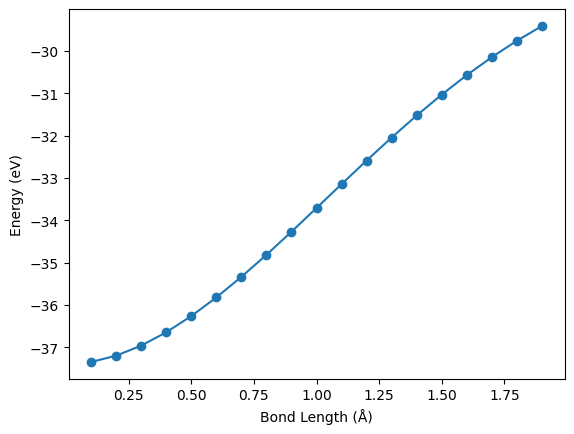

In [19]:
# plot the energy vs bond length
plt.plot(bond_len, energies,marker='o')
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy (eV)')

### Problem 8. Implement EHT to calculate MO and orbital energies of HF and HLi molecules
(a) Treat HF molecule; (b) Treat HLi molecule using EHT and construct the MO diagram

In [ ]:
hf = extended_huckel('hf.xyz',numerical=True)
hli = extended_huckel('hli.xyz',numerical=True)

<Axes: xlabel='EHT MO for hli', ylabel='Energy (eV)'>

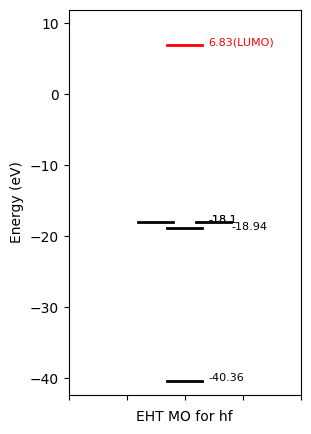

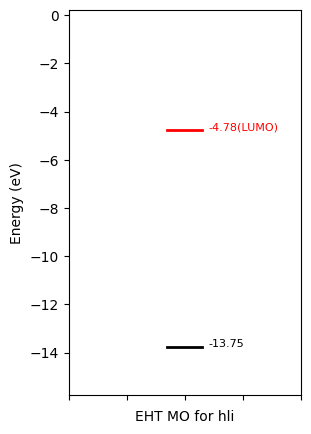

In [27]:
hf.plot_MO_diagram()
hli.plot_MO_diagram()

In [22]:
# orbitals of HF
pd.DataFrame(hf.coeff)

,0,1,2,3,4
0,-0.112098,0.223781,0.0,0.0,1.228369
1,-0.943404,-0.138920,0.0,0.0,-0.659033
2,0.024209,0.898123,0.0,0.0,-0.648607
3,0.000000,0.000000,1.0,0.0,0.000000
4,0.000000,0.000000,0.0,1.0,0.000000


In [23]:
# orbitals of HLi
pd.DataFrame(hli.coeff)

,0,1,2,3,4
0,-0.931730,-0.132343,0.0,0.0,-0.794673
1,-0.110888,0.867375,0.0,0.0,0.645470
2,0.051858,0.497534,0.0,0.0,-1.041943
3,0.000000,0.000000,1.0,0.0,0.000000
4,0.000000,0.000000,0.0,1.0,0.000000


### Problem 9. Calculation of EHT-based resconance energy of cyclobutadiene using ethylene as reference.

In [24]:
ethylene = extended_huckel('ethylene.xyz',numerical=False)
cyclobutadiene = extended_huckel('cyclobutadiene.xyz',numerical=False)

In [ ]:
# this is for getting the pi bonding orbitals. Only C_pz orbitals are used
cyclobutadiene.mol_orbs = [cyclobutadiene.mol_orbs[i] for i in [3,7,11,15]]
cyclobutadiene.ionization_energy = {'C':[11.4]}
cyclobutadiene.atomnames = ['C','C','C','C']
cyclobutadiene.numerical = True
cyclobutadiene.calc()

<Axes: xlabel='EHT MO for cyclobutadiene', ylabel='Energy (eV)'>

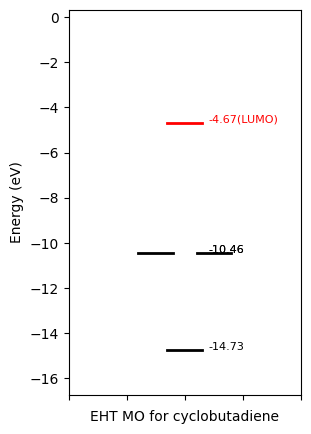

In [28]:
# cyclobutadiene MO with only pz orbitals
cyclobutadiene.mo_occ = 3
cyclobutadiene.plot_MO_diagram()

In [29]:
pd.DataFrame(cyclobutadiene.coeff)

,0,1,2,3
0,-0.390508,0.526897,0.526897,-0.66839
1,-0.390508,0.526897,-0.526897,0.66839
2,-0.390508,-0.526897,-0.526897,-0.66839
3,-0.390508,-0.526897,0.526897,0.66839


<Axes: xlabel='EHT MO for ethylene', ylabel='Energy (eV)'>

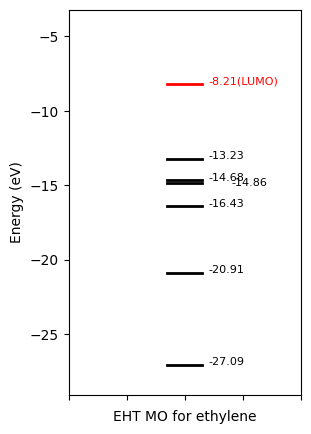

In [30]:
ethylene.plot_MO_diagram()

In [31]:
# orbitals of ethylene, 6th orbital is the pi bonding orbital
pd.DataFrame(ethylene.coeff_)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.491435,-0.391414,0.000000,0.000000,-0.059366,0.000000,0.000000,0.000000,0.209747,0.000000,0.789324,-1.431183
1,0.040460,0.180515,0.040088,0.041089,-0.476677,-0.189753,0.250781,0.080467,-0.895684,0.113014,-0.513024,-0.772019
2,0.008944,0.039906,-0.336570,-0.344978,-0.105377,0.199535,-0.263708,-0.675578,-0.198006,-0.948838,-0.113413,-0.170667
3,0.010461,0.046673,0.132725,0.136040,-0.123246,0.563302,-0.744469,0.266411,-0.231580,0.374170,-0.132643,-0.199607
4,0.491435,0.391414,0.000000,0.000000,-0.059366,0.000000,0.000000,0.000000,-0.209747,0.000000,0.789324,1.431183
5,-0.040460,0.180515,0.040088,-0.041089,0.476677,-0.189753,-0.250781,0.080467,-0.895684,-0.113014,0.513024,-0.772019
6,-0.008944,0.039906,-0.336570,0.344978,0.105377,0.199535,0.263708,-0.675578,-0.198006,0.948838,0.113413,-0.170667
7,-0.010461,0.046673,0.132725,-0.136040,0.123246,0.563302,0.744469,0.266411,-0.231580,-0.374170,0.132643,-0.199607
8,0.094441,-0.233516,-0.275539,-0.353085,0.214387,0.000000,0.000000,0.627676,-0.584354,0.626953,-0.654120,0.317188
9,0.094441,-0.233516,0.275539,0.353085,0.214387,0.000000,0.000000,-0.627674,-0.584356,-0.626951,-0.654122,0.317189


### Problem 10. Calculate the MO of formylaldehyde using EHT and find non-bonding Oxygen electrons

In [32]:
formaldehyde = extended_huckel('CH2O.xyz',numerical=False)

<Axes: xlabel='EHT MO for CH2O', ylabel='Energy (eV)'>

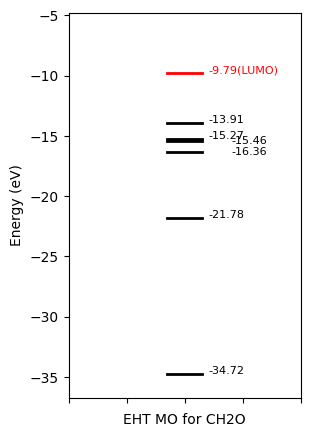

In [33]:
formaldehyde.plot_MO_diagram()

The 4th MO orbital is the most likely for non-bonding oxygen electrons. Because the coefficient of the 4th MO orbital is the highest for the oxygen pz orbital. It is without contributions from 1s orbitals of hydrogen atoms and 2s orbitals of carbon atoms.

In [34]:
pd.DataFrame(formaldehyde.coeff_)

,0,1,2,3,4,5,6,7,8,9
0,-0.291582,0.526559,0.000000,0.000000,-0.007540,0.000000,0.000000,0.000000,0.713954,-1.235586
1,-0.128352,-0.273385,-0.050654,0.026435,-0.239234,-0.029023,0.072929,-0.137638,-1.065859,-0.761921
2,0.014556,0.031005,-0.443312,-0.006807,0.027132,-0.253998,-0.018780,-1.204558,0.120883,0.086411
3,0.010044,0.021393,-0.004828,0.347682,0.018720,-0.002766,0.959206,-0.013119,0.083405,0.059621
4,-0.792285,-0.313024,0.000000,0.000000,0.142099,0.000000,0.000000,0.000000,0.377912,0.920553
5,-0.034931,-0.237758,-0.059393,0.065639,0.852990,0.095676,-0.041340,0.031292,-0.215342,-0.734936
6,0.003962,0.026964,-0.519789,-0.016902,-0.096738,0.837333,0.010645,0.273873,0.024421,0.083349
7,0.002733,0.018605,-0.005661,0.863317,-0.066747,0.009119,-0.543731,0.002983,0.016851,0.057510
8,-0.019763,0.264025,0.315926,0.000000,0.177426,0.345642,0.000000,-0.856620,-0.842232,0.383884
9,-0.019763,0.264025,-0.315926,0.000000,0.177427,-0.345642,0.000000,0.856616,-0.842238,0.383883
